In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor


In [2]:
output_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(output_path)
merged_df = merged_df.rename(columns={'total_year': 'HDD_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

np.random.seed(123)
merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

In [3]:


def calculate_metrics(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAPE": np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        "WAPE": np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100
    }

def train_and_evaluate_model(X_train, X_test, y_train, y_test, model_type='lr'):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    if model_type == 'lr':
        model = LinearRegression()
    elif model_type == 'knn':
        model = KNeighborsRegressor(n_neighbors=6)
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return calculate_metrics(y_test, y_pred)

def add_metadata(metrics, region, target, strategy, features_used, model_type):
    model_name = 'Linear Regression' if model_type == 'lr' else 'KNN'
    metrics.update({
        'Region': region,
        'Target': target,
        'Strategy': strategy,
        'Model': model_name,
        'Features Used': ', '.join(features_used)
    })
    return metrics

def reorder_columns(df):
    column_order = [
        'Region', 'Target', 'Strategy', 'Model', 'Features Used', 'Features Abbreviated',
        'MSE', 'R²', 'MAE', 'RMSE', 'MAPE', 'WAPE'
    ]
    existing_columns = df.columns.tolist()
    final_columns = [col for col in column_order if col in existing_columns]
    return df[final_columns]

def within_domain(df, features, target_columns, model_type):
    results = []
    for region in df['Region Grouped'].unique():
        region_data = df[df['Region Grouped'] == region].copy()
        mask = region_data['is_train'] == 1
        
        for target in target_columns:
            X_train = region_data[features][mask]
            X_test = region_data[features][~mask]
            y_train = region_data[target][mask]
            y_test = region_data[target][~mask]
            
            metrics = train_and_evaluate_model(X_train, X_test, y_train, y_test, model_type)
            results.append(add_metadata(metrics, region, target, 'Within-Domain', features, model_type))
    return reorder_columns(pd.DataFrame(results).round(2))

def cross_domain(df, features, target_columns, model_type):
    results = []
    regions = df['Region Grouped'].unique()
    
    for test_region in regions:
        train_data = df[df['Region Grouped'] != test_region]
        test_data = df[df['Region Grouped'] == test_region]
        
        for target in target_columns:
            X_train = train_data[features]
            X_test = test_data[features]
            y_train = train_data[target]
            y_test = test_data[target]
            
            metrics = train_and_evaluate_model(X_train, X_test, y_train, y_test, model_type)
            results.append(add_metadata(metrics, test_region, target, 'Cross-Domain', features, model_type))
    return reorder_columns(pd.DataFrame(results).round(2))

def all_domain(df, features, target_columns, model_type):
    results = []
    regions = df['Region Grouped'].unique()
    
    train_mask = df['is_train'] == 1
    X_train_all = df[features][train_mask]
    
    for region in regions:
        test_mask = (df['Region Grouped'] == region) & (df['is_train'] == 0)
        test_data = df[test_mask]
        
        for target in target_columns:
            y_train = df[target][train_mask]
            y_test = test_data[target]
            X_test = test_data[features]
            
            metrics = train_and_evaluate_model(X_train_all, X_test, y_train, y_test, model_type)
            results.append(add_metadata(metrics, region, target, 'All-Domain', features, model_type))
    return reorder_columns(pd.DataFrame(results).round(2))

def add_abbreviated_feature_column(df, features, feature_abbreviations):
    abbreviated_features = [feature_abbreviations.get(feature, feature) for feature in features]
    df['Features Abbreviated'] = ' | '.join(abbreviated_features)
    return df

def append_total_row(df):
    total_row_df = pd.DataFrame()
    
    for target in df['Target'].unique():
        target_df = df[df['Target'] == target]
        metrics_avg = target_df[['MSE', 'R²', 'MAE', 'RMSE', 'MAPE', 'WAPE']].mean()
        
        total_row = {
            'Region': 'Total',
            'Target': target,
            'Strategy': df['Strategy'].iloc[0],
            'Model': df['Model'].iloc[0],
            'Features Used': df['Features Used'].iloc[0],
            'Features Abbreviated': df.get('Features Abbreviated', [''])[0],
            'MSE': metrics_avg['MSE'],
            'R²': metrics_avg['R²'],
            'MAE': metrics_avg['MAE'],
            'RMSE': metrics_avg['RMSE'],
            'MAPE': metrics_avg['MAPE'],
            'WAPE': metrics_avg['WAPE']
        }
        
        total_row_df = pd.concat([total_row_df, pd.DataFrame([total_row])], ignore_index=True)
    
    return reorder_columns(pd.concat([df, total_row_df], ignore_index=True))

def filter_and_concatenate(*dfs):
    filtered_dfs = [df[df['Region'] == 'Total'] for df in dfs]
    concatenated_df = pd.concat(filtered_dfs, ignore_index=True)
    return concatenated_df

def run_all_strategies(df, features, target_columns, model_type):
    within_domain_results = within_domain(df, features, target_columns, model_type)
    cross_domain_results = cross_domain(df, features, target_columns, model_type)
    all_domain_results = all_domain(df, features, target_columns, model_type)
    return within_domain_results, cross_domain_results, all_domain_results



In [4]:
features = [
    "HDD_total_year", 
    "GDP_per_capita", 
    "Urbanization_Rate_2022",
    "latitude",
    "longitude",  
    "Paris_Agreement",
    "Subnational HDI", 
    "Educational index", 
    "Income index"
]

feature_abbreviations = {
    "HDD_total_year": "HDD",
    "GDP_per_capita": "GDP",
    "Urbanization_Rate_2022": "URB",
    "latitude": "Lat",
    "longitude": "Long",
    "Paris_Agreement": "Paris",
    "Subnational HDI": "HDI", 
    "Educational index": "EDU" , 
    "Income index": "Income"
}

target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

In [5]:
# Linear Regression
within_domain_results_lr, cross_domain_results_lr, all_domain_results_lr = run_all_strategies(
    df=merged_df,
    features=features,
    target_columns=target_columns,
    model_type='lr'
)

# KNN
within_domain_results_knn, cross_domain_results_knn, all_domain_results_knn = run_all_strategies(
    df=merged_df,
    features=features,
    target_columns=target_columns,
    model_type='knn'
)

# Linear Regression
within_domain_results_lr = add_abbreviated_feature_column(within_domain_results_lr, features, feature_abbreviations)
cross_domain_results_lr = add_abbreviated_feature_column(cross_domain_results_lr, features, feature_abbreviations)
all_domain_results_lr = add_abbreviated_feature_column(all_domain_results_lr, features, feature_abbreviations)

within_domain_results_lr = append_total_row(within_domain_results_lr)
cross_domain_results_lr = append_total_row(cross_domain_results_lr)
all_domain_results_lr = append_total_row(all_domain_results_lr)

# KNN
within_domain_results_knn = add_abbreviated_feature_column(within_domain_results_knn, features, feature_abbreviations)
cross_domain_results_knn = add_abbreviated_feature_column(cross_domain_results_knn, features, feature_abbreviations)
all_domain_results_knn = add_abbreviated_feature_column(all_domain_results_knn, features, feature_abbreviations)

within_domain_results_knn = append_total_row(within_domain_results_knn)
cross_domain_results_knn = append_total_row(cross_domain_results_knn)
all_domain_results_knn = append_total_row(all_domain_results_knn)

# Concatenate results
concatenated_results_lr = filter_and_concatenate(
    within_domain_results_lr,
    cross_domain_results_lr,
    all_domain_results_lr
)

concatenated_results_knn = filter_and_concatenate(
    within_domain_results_knn,
    cross_domain_results_knn,
    all_domain_results_knn
)

In [6]:
concatenated_results_lr.sort_values(by=['Target', 'Strategy'], ascending=[True, False])


,Region,Target,Strategy,Model,Features Used,Features Abbreviated,MSE,R²,MAE,RMSE,MAPE,WAPE
1,Total,Non-residential EUI (kWh/m2/year),Within-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,3634.652,-0.900,36.532,47.152,19.876,16.938
3,Total,Non-residential EUI (kWh/m2/year),Cross-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,4238.268,-12.850,50.058,60.408,31.890,31.102
5,Total,Non-residential EUI (kWh/m2/year),All-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,3530.940,-2.092,40.342,47.890,21.196,20.244
0,Total,Residential EUI (kWh/m2/year),Within-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,1811.468,-0.092,24.088,33.872,20.622,17.970
2,Total,Residential EUI (kWh/m2/year),Cross-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,2613.266,-1.918,40.806,48.450,40.592,34.984
4,Total,Residential EUI (kWh/m2/year),All-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,1486.338,-0.976,28.580,35.900,25.752,23.310


In [7]:
concatenated_results_knn.sort_values(by=['Target', 'Strategy'], ascending=[True, False])

,Region,Target,Strategy,Model,Features Used,Features Abbreviated,MSE,R²,MAE,RMSE,MAPE,WAPE
1,Total,Non-residential EUI (kWh/m2/year),Within-Domain,KNN,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,1436.984,-0.066,21.120,31.004,10.362,10.086
3,Total,Non-residential EUI (kWh/m2/year),Cross-Domain,KNN,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,3468.936,-10.478,35.506,52.192,20.878,20.568
5,Total,Non-residential EUI (kWh/m2/year),All-Domain,KNN,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,1290.362,0.116,18.944,29.862,9.556,9.260
0,Total,Residential EUI (kWh/m2/year),Within-Domain,KNN,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,1044.170,0.316,20.224,27.752,15.398,15.372
2,Total,Residential EUI (kWh/m2/year),Cross-Domain,KNN,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,2493.306,-1.738,36.938,47.342,31.884,30.870
4,Total,Residential EUI (kWh/m2/year),All-Domain,KNN,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,1042.280,0.302,20.144,27.354,15.312,15.374


# Experiments - Within Domain 

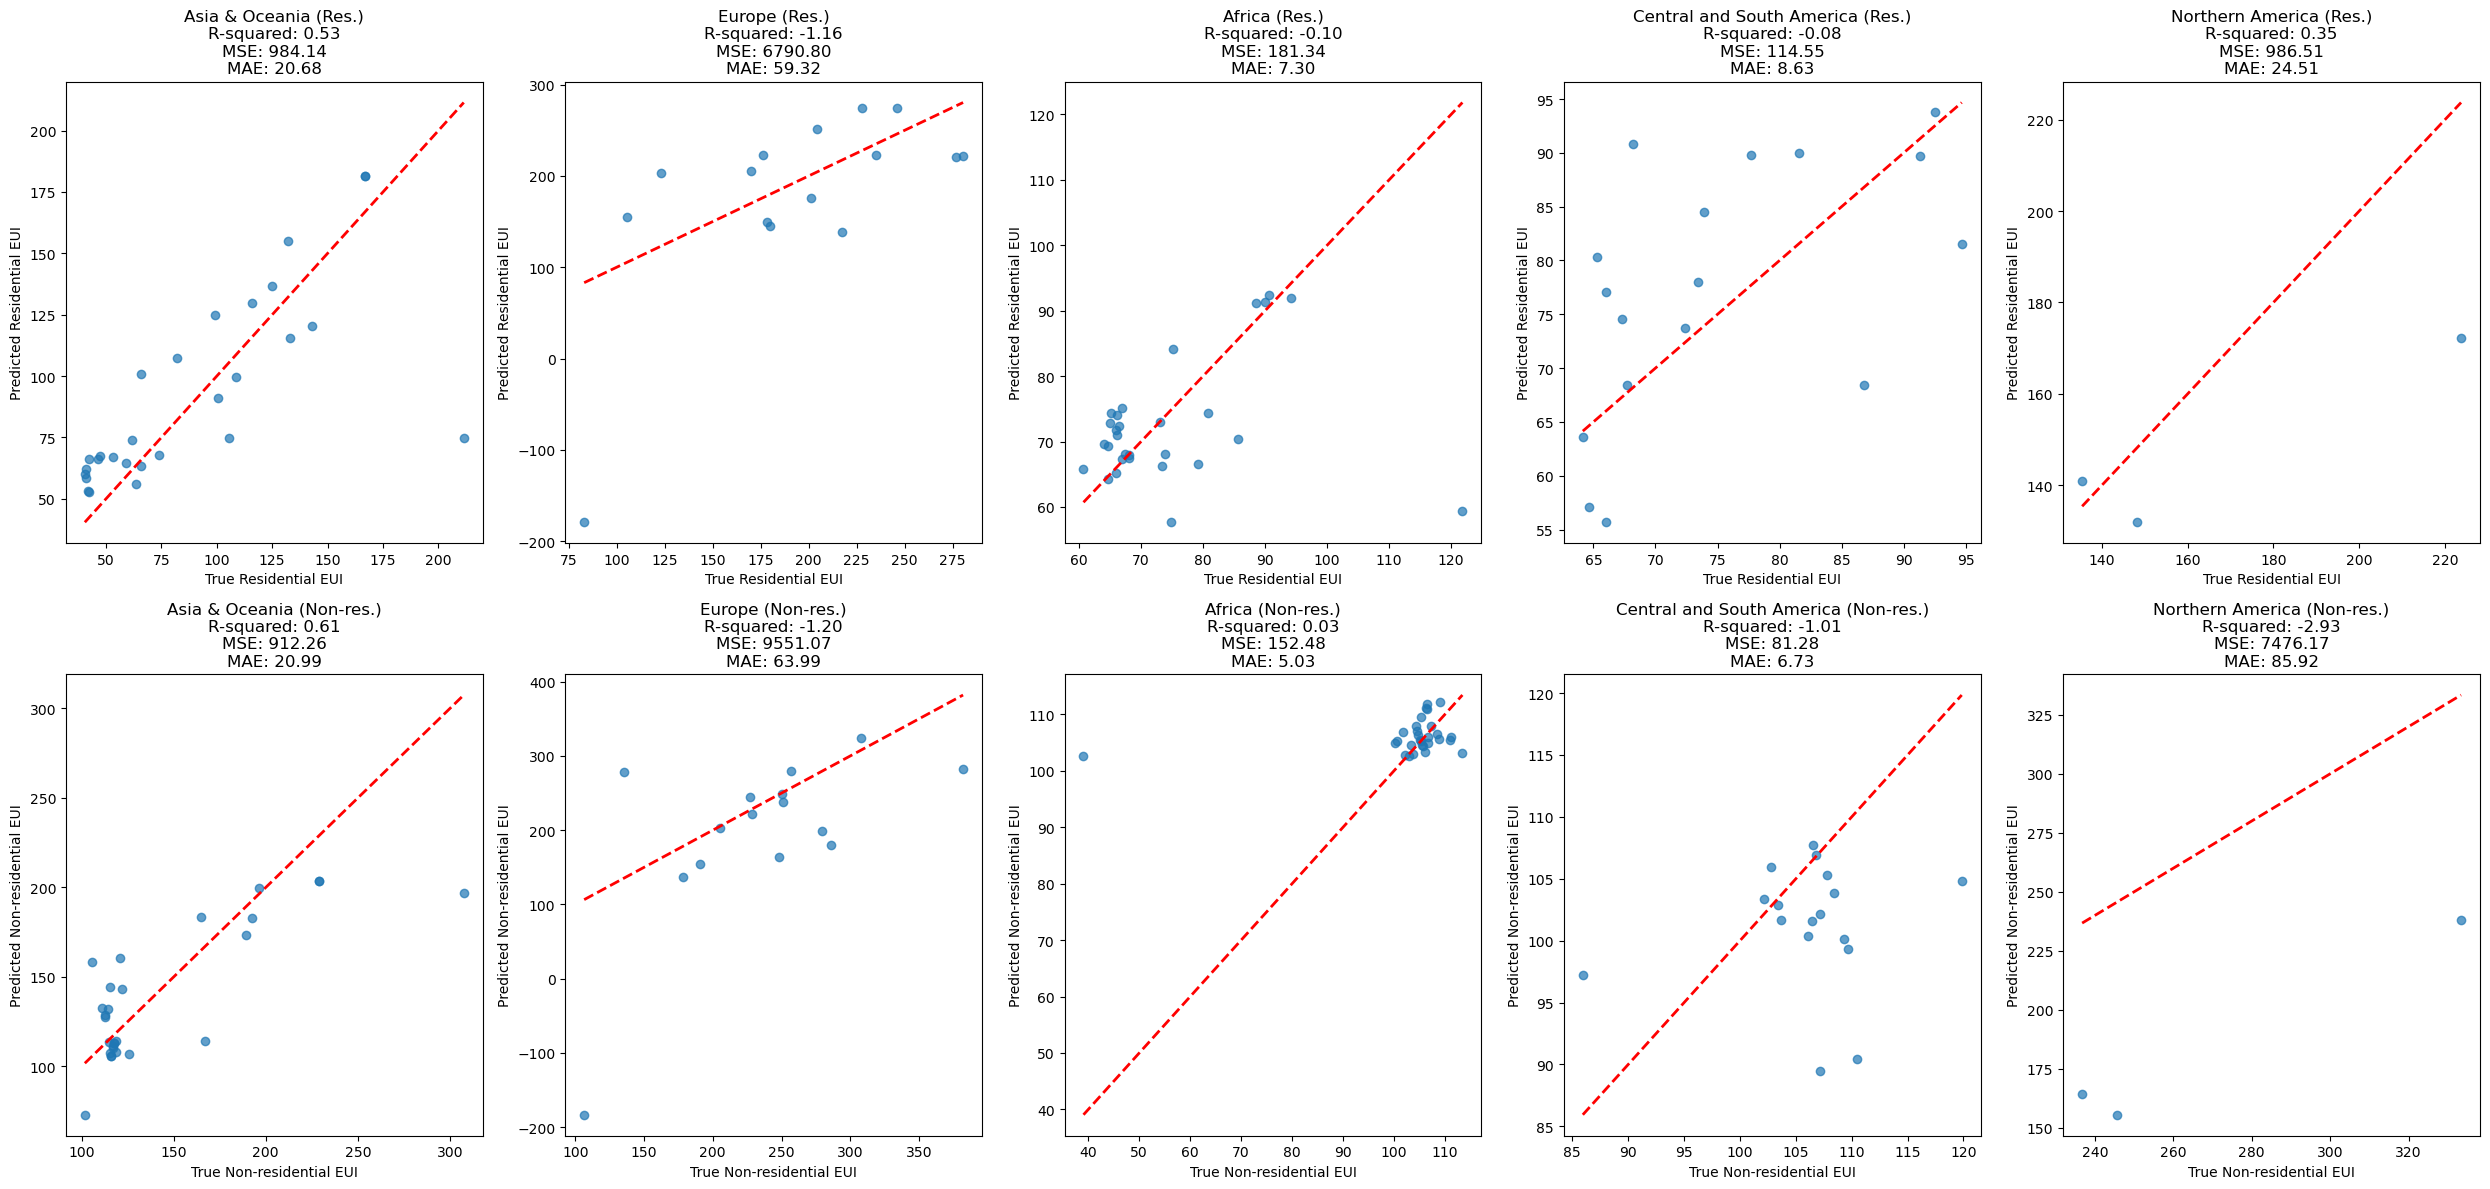

In [8]:
 ## WITHIN DOMAIN

import os
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# Load the merged dataframe
output_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(output_path)
merged_df = merged_df.rename(columns={'total_year': 'HDD_total_year'})

# Calculate GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporary)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

# Split into training and test sets
np.random.seed(123)
merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

# Select features
features = [
    "HDD_total_year", 
    "GDP_per_capita", 
    "Urbanization_Rate_2022",
    "latitude",
    "longitude",  
    "Paris_Agreement",
    "Subnational HDI", 
    "Educational index", 
    "Income index"
]

# Define the regions to loop through
regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']

# Prepare the plot
fig, axes = plt.subplots(2, 5, figsize=(25, 12))  # 2 rows, 5 columns
axes = axes.flatten()

# Loop through each region and train models for both target variables
for i, region in enumerate(regions):
    region_df = merged_df[merged_df['Region Grouped'] == region]
    X_train = region_df[region_df['is_train'] == 1][features]
    X_test = region_df[region_df['is_train'] == 0][features]
    y_train_res = region_df[region_df['is_train'] == 1]['Residential EUI (kWh/m2/year)']
    y_test_res = region_df[region_df['is_train'] == 0]['Residential EUI (kWh/m2/year)']
    y_train_non_res = region_df[region_df['is_train'] == 1]['Non-residential EUI (kWh/m2/year)']
    y_test_non_res = region_df[region_df['is_train'] == 0]['Non-residential EUI (kWh/m2/year)']

    # Train the linear regression model for Residential EUI
    model_res = LinearRegression()
    model_res.fit(X_train, y_train_res)
    y_pred_res = model_res.predict(X_test)
    mse_res = mean_squared_error(y_test_res, y_pred_res)
    r2_res = r2_score(y_test_res, y_pred_res)
    mae_res = mean_absolute_error(y_test_res, y_pred_res)

    # Train the linear regression model for Non-residential EUI
    model_non_res = LinearRegression()
    model_non_res.fit(X_train, y_train_non_res)
    y_pred_non_res = model_non_res.predict(X_test)
    mse_non_res = mean_squared_error(y_test_non_res, y_pred_non_res)
    r2_non_res = r2_score(y_test_non_res, y_pred_non_res)
    mae_non_res = mean_absolute_error(y_test_non_res, y_pred_non_res)

    # Plot for Residential EUI
    axes[i].scatter(y_test_res, y_pred_res, alpha=0.7)
    axes[i].plot([y_test_res.min(), y_test_res.max()], [y_test_res.min(), y_test_res.max()], 'r--', lw=2)
    axes[i].set_xlabel('True Residential EUI')
    axes[i].set_ylabel('Predicted Residential EUI')
    axes[i].set_title(f'{region} (Res.)\nR-squared: {r2_res:.2f}\nMSE: {mse_res:.2f}\nMAE: {mae_res:.2f}')

    # Plot for Non-residential EUI
    axes[i + 5].scatter(y_test_non_res, y_pred_non_res, alpha=0.7)
    axes[i + 5].plot([y_test_non_res.min(), y_test_non_res.max()], [y_test_non_res.min(), y_test_non_res.max()], 'r--', lw=2)
    axes[i + 5].set_xlabel('True Non-residential EUI')
    axes[i + 5].set_ylabel('Predicted Non-residential EUI')
    axes[i + 5].set_title(f'{region} (Non-res.)\nR-squared: {r2_non_res:.2f}\nMSE: {mse_non_res:.2f}\nMAE: {mae_non_res:.2f}')
    

# Adjust layout
plt.tight_layout()
plt.show()


In [9]:
within_domain_results_lr

,Region,Target,Strategy,Model,Features Used,Features Abbreviated,MSE,R²,MAE,RMSE,MAPE,WAPE
0,Asia & Oceania,Residential EUI (kWh/m2/year),Within-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,984.140,0.530,20.680,31.370,25.670,23.370
1,Asia & Oceania,Non-residential EUI (kWh/m2/year),Within-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,912.260,0.610,20.990,30.200,14.410,14.740
2,Europe,Residential EUI (kWh/m2/year),Within-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,6790.800,-1.160,59.320,82.410,44.040,30.630
3,Europe,Non-residential EUI (kWh/m2/year),Within-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,9551.070,-1.200,63.990,97.730,38.450,27.160
4,Africa,Residential EUI (kWh/m2/year),Within-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,181.340,-0.100,7.300,13.470,8.910,9.830
5,Africa,Non-residential EUI (kWh/m2/year),Within-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,152.480,0.030,5.030,12.350,8.270,4.860
6,Central and South America,Residential EUI (kWh/m2/year),Within-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,114.550,-0.080,8.630,10.700,11.750,11.530
7,Central and South America,Non-residential EUI (kWh/m2/year),Within-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,81.280,-1.010,6.730,9.020,6.300,6.340
8,Northern America,Residential EUI (kWh/m2/year),Within-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,986.510,0.350,24.510,31.410,12.740,14.490
9,Northern America,Non-residential EUI (kWh/m2/year),Within-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,7476.170,-2.930,85.920,86.460,31.950,31.590


# Experiments - Cross Domain 

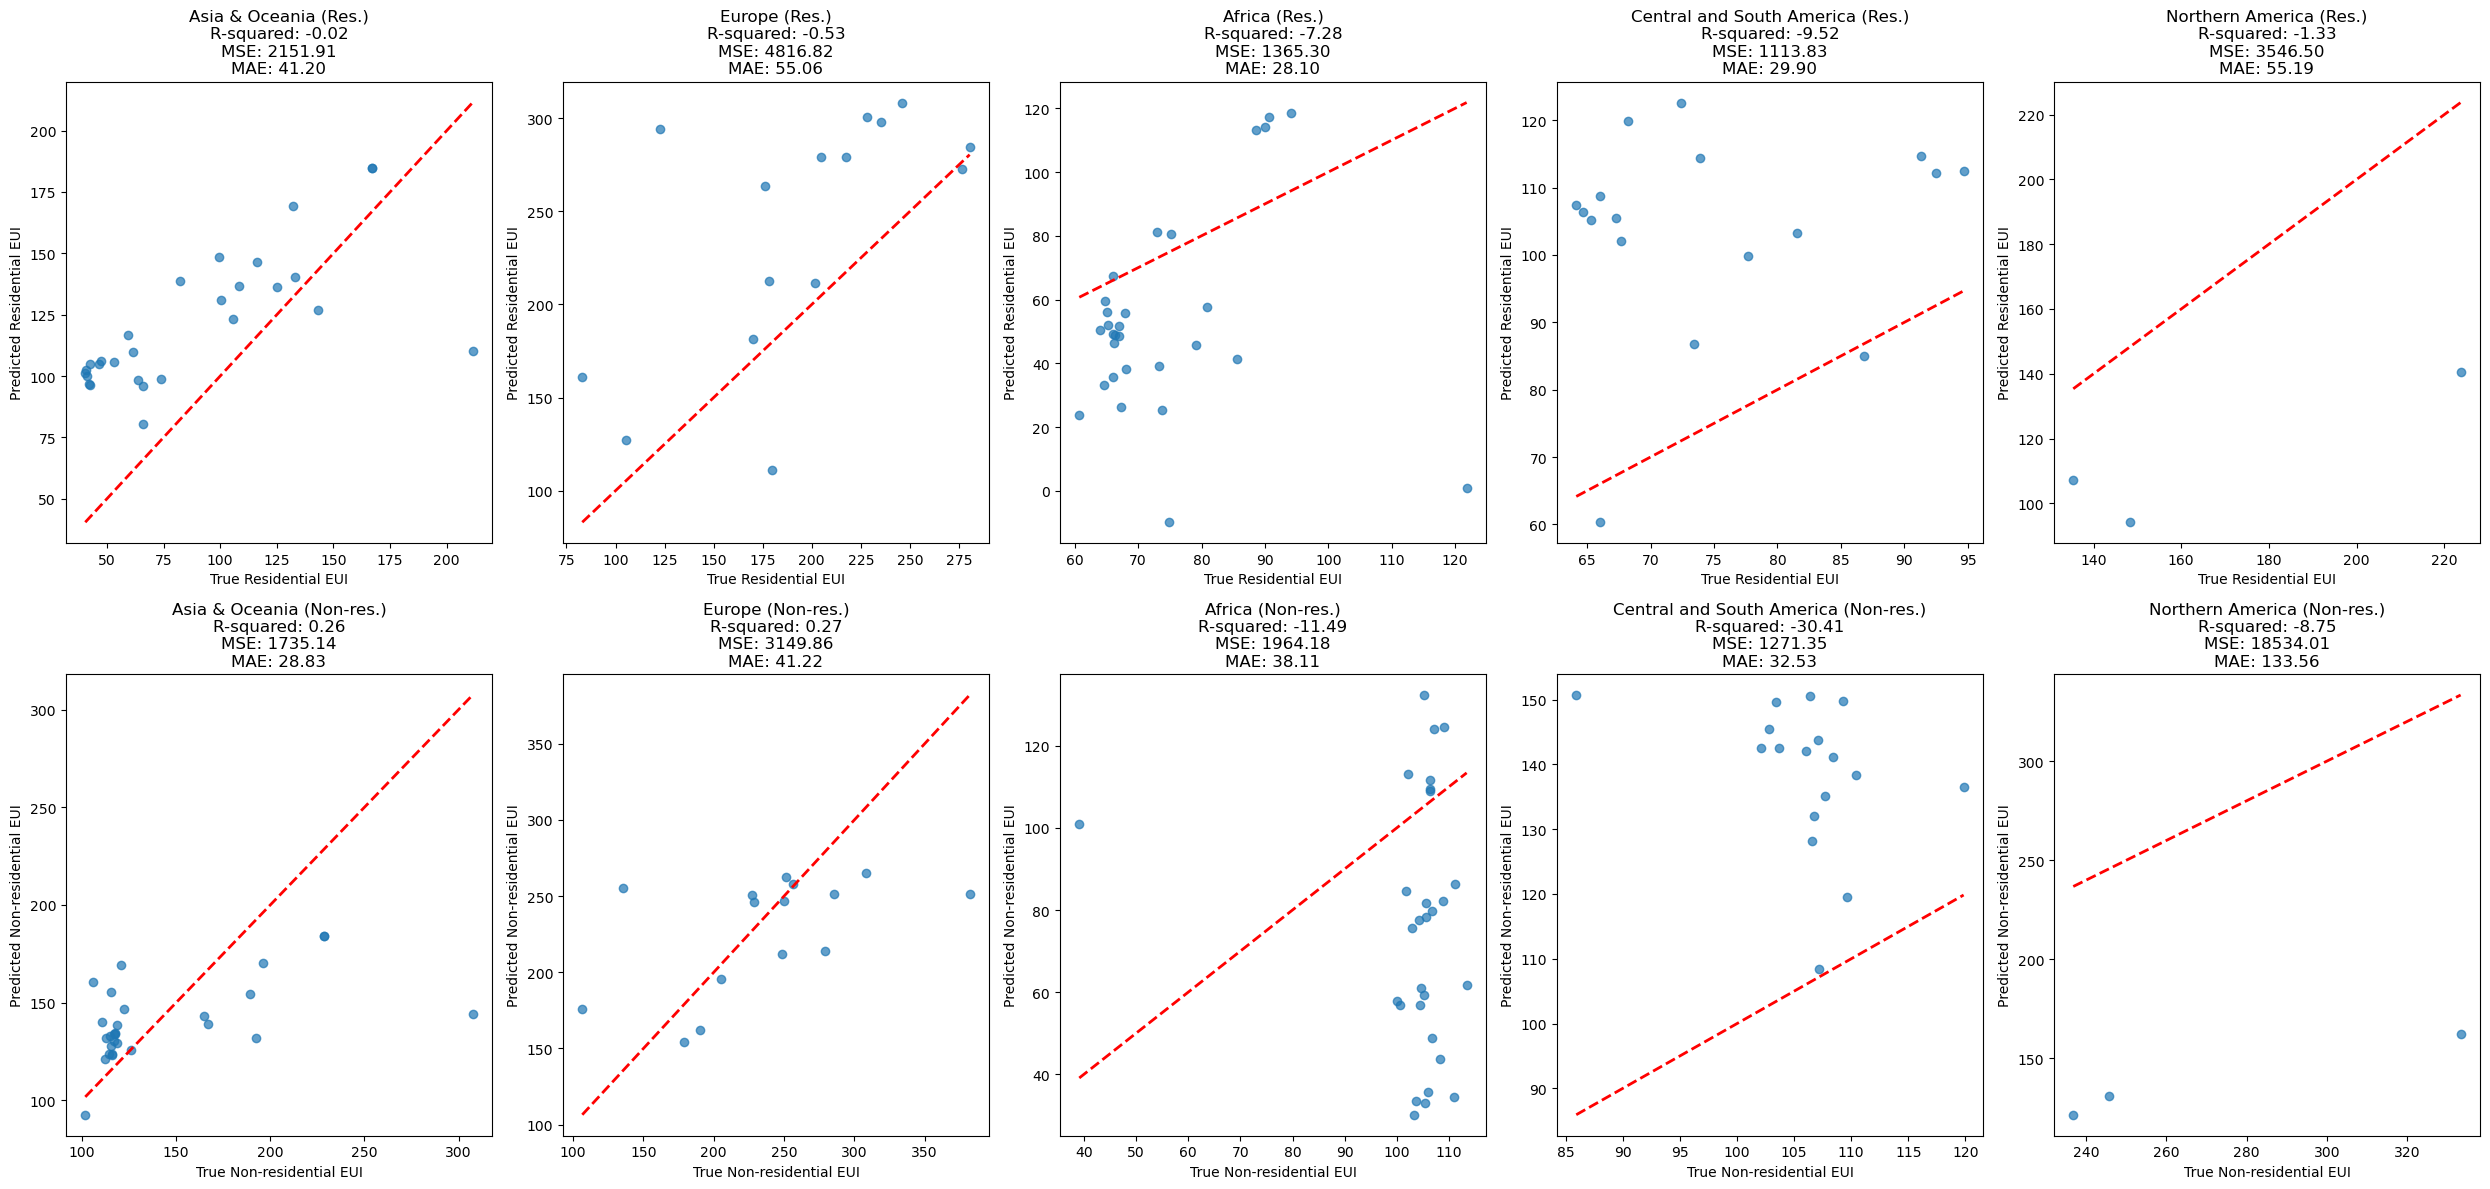

In [13]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# Load the merged dataframe
output_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(output_path)
merged_df = merged_df.rename(columns={'total_year': 'HDD_total_year'})

# Calculate GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporary)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

# Split into training and test sets
np.random.seed(123)
merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

# Select features
features = [
    "HDD_total_year", 
    "GDP_per_capita", 
    "Urbanization_Rate_2022",
    "latitude",
    "longitude",  
    "Paris_Agreement",
    "Subnational HDI", 
    "Educational index", 
    "Income index"
]

# Define the regions to loop through
regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']

# Prepare the plot
fig, axes = plt.subplots(2, 5, figsize=(25, 12))  # 2 rows, 5 columns
axes = axes.flatten()

# Loop through each region and train models for both target variables
for i, region in enumerate(regions):
    # Filter out the current region for training (cross-domain)
    train_df = merged_df[merged_df['Region Grouped'] != region]
    test_df = merged_df[merged_df['Region Grouped'] == region]

    # Features and target variables for training
    X_train = train_df[train_df['is_train'] == 1][features]
    y_train_res = train_df[train_df['is_train'] == 1]['Residential EUI (kWh/m2/year)']
    y_train_non_res = train_df[train_df['is_train'] == 1]['Non-residential EUI (kWh/m2/year)']
    
    # Features and target variables for testing
    X_test = test_df[test_df['is_train'] == 0][features]
    y_test_res = test_df[test_df['is_train'] == 0]['Residential EUI (kWh/m2/year)']
    y_test_non_res = test_df[test_df['is_train'] == 0]['Non-residential EUI (kWh/m2/year)']

    # Train the linear regression model for Residential EUI
    model_res = LinearRegression()
    model_res.fit(X_train, y_train_res)
    y_pred_res = model_res.predict(X_test)
    mse_res = mean_squared_error(y_test_res, y_pred_res)
    r2_res = r2_score(y_test_res, y_pred_res)
    mae_res = mean_absolute_error(y_test_res, y_pred_res)

    # Train the linear regression model for Non-residential EUI
    model_non_res = LinearRegression()
    model_non_res.fit(X_train, y_train_non_res)
    y_pred_non_res = model_non_res.predict(X_test)
    mse_non_res = mean_squared_error(y_test_non_res, y_pred_non_res)
    r2_non_res = r2_score(y_test_non_res, y_pred_non_res)
    mae_non_res = mean_absolute_error(y_test_non_res, y_pred_non_res)

    # Plot for Residential EUI
    axes[i].scatter(y_test_res, y_pred_res, alpha=0.7)
    axes[i].plot([y_test_res.min(), y_test_res.max()], [y_test_res.min(), y_test_res.max()], 'r--', lw=2)
    axes[i].set_xlabel('True Residential EUI')
    axes[i].set_ylabel('Predicted Residential EUI')
    axes[i].set_title(f'{region} (Res.)\nR-squared: {r2_res:.2f}\nMSE: {mse_res:.2f}\nMAE: {mae_res:.2f}')

    # Plot for Non-residential EUI
    axes[i + 5].scatter(y_test_non_res, y_pred_non_res, alpha=0.7)
    axes[i + 5].plot([y_test_non_res.min(), y_test_non_res.max()], [y_test_non_res.min(), y_test_non_res.max()], 'r--', lw=2)
    axes[i + 5].set_xlabel('True Non-residential EUI')
    axes[i + 5].set_ylabel('Predicted Non-residential EUI')
    axes[i + 5].set_title(f'{region} (Non-res.)\nR-squared: {r2_non_res:.2f}\nMSE: {mse_non_res:.2f}\nMAE: {mae_non_res:.2f}')
    

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
cross_domain_results_lr


,Region,Target,Strategy,Model,Features Used,Features Abbreviated,MSE,R²,MAE,RMSE,MAPE,WAPE
0,Asia & Oceania,Residential EUI (kWh/m2/year),Cross-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,2693.670,0.200,40.180,51.900,61.380,43.770
1,Asia & Oceania,Non-residential EUI (kWh/m2/year),Cross-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,1277.370,0.280,25.830,35.740,18.850,19.380
2,Europe,Residential EUI (kWh/m2/year),Cross-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,5829.500,-0.010,60.290,76.350,36.660,28.720
3,Europe,Non-residential EUI (kWh/m2/year),Cross-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,5544.710,0.260,51.630,74.460,26.040,22.650
4,Africa,Residential EUI (kWh/m2/year),Cross-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,1023.700,-5.640,27.310,32.000,37.980,38.220
5,Africa,Non-residential EUI (kWh/m2/year),Cross-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,1824.540,-25.890,35.480,42.710,34.490,33.800
6,Central and South America,Residential EUI (kWh/m2/year),Cross-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,1032.170,-2.550,29.030,32.130,38.330,35.530
7,Central and South America,Non-residential EUI (kWh/m2/year),Cross-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,2292.540,-31.940,43.830,47.880,42.970,41.800
8,Northern America,Residential EUI (kWh/m2/year),Cross-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,2487.290,-1.590,47.220,49.870,28.610,28.680
9,Northern America,Non-residential EUI (kWh/m2/year),Cross-Domain,Linear Regression,"HDD_total_year, GDP_per_capita, Urbanization_R...",HDD | GDP | URB | Lat | Long | Paris | HDI | E...,10252.180,-6.960,93.520,101.250,37.100,37.880
